## Initial EDA

#Imports

In [ ]:
%pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.0/290.0 KB 4.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve, auc, accuracy_score, mean_squared_error, roc_auc_score
from sklearn.utils import class_weight
from scipy.stats import norm, entropy
from feature_engine.creation import CyclicalFeatures

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#remove if data is not imbalanced
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler



#Loading Dataset

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1i-JbDm2nY15NnYl62GxlsBCoELp1HJZ3")

In [ ]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [ ]:
df.nunique()

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                              333
company                            352
days_in_waiting_list     

With the dataset having two distinct hotel types, we perform an EDA on both separately and combined, allowing us to identify patterns that may be present in one and not the other.

#Exploratory Data Analysis

##EDA Functions

###Null analysis

In [ ]:
def get_number_of_nulls(df):
    return df.isnull().sum()

In [ ]:
def get_rate_of_nulls(df):
    return df.isnull().mean() * 100

In [ ]:
def show_null_heatmap(df):
    plt.figure(figsize = (23,5))
    sns.set(font_scale=1.4)
    heatmap = sns.heatmap(df.isnull(), xticklabels=True)
    plt.show()

###Imbalance analysis

In [ ]:
def get_relative_entropy(df):
    total_bookings = df["is_canceled"].count()
    total_cancelations = df["is_canceled"].sum()
    relative_entropy = entropy([total_cancelations/total_bookings, (total_bookings - total_cancelations)/total_bookings], base=2)
    return relative_entropy

###Categorical analysis

In [ ]:
def show_categorical_values(df, categoricals):
    alignment = len(max(categoricals, key=len))
    for cat in categoricals:
        print(f"{cat.ljust(alignment)}: {df[cat].unique()}")

In [ ]:
def analyse_category(df, category):
    total = df[category].count()
    return df.groupby(category)[category].count() / total * 100

###Data Visualisation

In [ ]:
from tables.index import Index
def visualize_categoricals(df, categoricals):
    plt.rcParams.update({'font.size': 9})
    num_columns = 3
    num_rows = math.ceil(len(categoricals) / 3)
    
    fig, ax = plt.subplots(num_rows, num_columns, figsize=(30,num_rows*6))

    for row in range(num_rows):
        for col in range(num_columns):
            index = row*num_columns + col
            if index >= len(categoricals):
                fig.delaxes(ax[row][col])
            else:
                ax[row, col].set_title(categoricals[index], fontweight="bold")
                bars = ax[row, col].bar(df[categoricals[index]].dropna().unique(), df[categoricals[index]].value_counts())
    plt.show()

In [ ]:
def show_correlation_matrix(df):
    corr_matrix = df.corr()

    # Visualize correleation matirx
    plt.figure(figsize = (10,6))
    sns.heatmap(corr_matrix)
    plt.show()

    
    corr_matrix = corr_matrix.apply(lambda value:value>=0.5).sum()>1
    print(pd.DataFrame(corr_matrix, columns=["correlation >= 0.5"]))

In [ ]:
def show_room_matched(df):
    df = df.copy()
    df['matched'] = df['reserved_room_type'] == df['assigned_room_type']

    grouped = df.groupby(['matched', 'is_canceled']).size().unstack(fill_value=0)
    ax = grouped.plot(kind='bar', stacked=True)

    ax.set_xlabel('Room Matched')
    ax.set_ylabel('Number of Rooms')
    ax.set_title('Cancellation of Rooms by Match Status')
    ax.legend(['Not Cancelled', 'Cancelled'])
    plt.show()
    matched = df.groupby('matched')['is_canceled'].apply(pd.DataFrame)
    # matched.rows = ["Room match", "Rate of cancelation"]
    # print("Room match status")
    display = pd.DataFrame(matched.mean() * 100, columns=["Rate of cancelation"]).rename_axis("Room match status")
    print(display)
    # lst = []
    # df = df.groupby("is_canceled")
    # lst.append([(df['matched']==True).count()/(df['matched']).count() * 100])
    # lst.append([(df['matched']==False).count()/(df['matched']).count() * 100])
    # print(pd.DataFrame(lst, index=["Room matched", "Room not matched"], columns=["Percent of rooms"]))


###Time Based Analysis

In [ ]:
def show_cancelations_by_time(df):
    # print(df)
    is_canceled_by_year = df.groupby("arrival_date_year")["is_canceled"]
    total_bookings = is_canceled_by_year.count()
    total_cancelations = is_canceled_by_year.sum()
    rate_of_cancelations = total_cancelations/total_bookings * 100

    new_df =pd.DataFrame(pd.concat([total_bookings, total_cancelations, rate_of_cancelations], axis=1))
    new_df.columns = ["total_bookings", "total_cancelations", "rate_of_cancelations"]
    print(new_df)

    comparative = {}
    comparative["mean"] = rate_of_cancelations.mean()
    comparative["std"] = rate_of_cancelations.std()
    print("\nMean/Standard Deviation of rate of cancelations")
    print(pd.Series(comparative))

In [ ]:
def show_start_end(df):
    holder = []
    for year in range(2015, 2018, 1):
        min = df.where(df["arrival_date_year"] == year)["arrival_date_week_number"].min()
        max = df.where(df["arrival_date_year"] == year)["arrival_date_week_number"].max()
        holder.append([year, min, max])
    print(pd.DataFrame(holder, columns=["Arrival Year", "Earliest arrival week", "Latest arrival week"]))

    

In [ ]:
def show_rate_of_cancelations_by_week(df):
    totals_per_week = df.rename(columns={"is_canceled":"total_bookings"}).groupby("arrival_date_week_number")["total_bookings"].count()
    cancelations_per_week = df.groupby("arrival_date_week_number")["is_canceled"].sum()
    mean = (cancelations_per_week / totals_per_week * 100).mean()
    plt.plot(list(cancelations_per_week / totals_per_week * 100), label="rate of cancelations")
    plt.axhline(mean, color="blue", label="mean rate of cancelations")
    plt.title("Rate of cancelations by week")
    plt.legend()
    plt.show()

    def plot_year(year, index):
        arrivals_cancelations = pd.DataFrame([cancelations_per_week_year[year], total_per_week_year[year]])
        net = total_per_week_year[year] - cancelations_per_week_year[year]
        mean_cancelations = cancelations_per_week_year[year].mean()
        mean_total = total_per_week_year[year].mean()
        mean_net = net.mean()
        
        ax[index].set_ylim((0,1600))
        ax[index].set_yticks(np.arange(0, 1601, 200))
        ax[index].set_xlim((0,53))
        ax[index].set_xticks(np.arange(0,53,2))
        # ax[index].axhline(mean_cancelations, color="r", label="mean cancelations")
        # ax[index].axhline(mean_total, color="g", label="mean totals")
        # ax[index].axhline(mean_net, color = "black", label="mean net sales")
        ax[index].plot(arrivals_cancelations.transpose(), label=["cancelations_per_week", "bookings_per_week"])
        ax[index].plot(net, label="net sales")
        ax[index].set_title(str(year))
        ax[index].legend()
    
    def plot_rate_year(year, index):
        # arrivals_cancelations = pd.DataFrame([cancelations_per_week_year[year], total_per_week_year[year]])
        rate = cancelations_per_week_year[year] / total_per_week_year[year] * 100
        ax[index].set_ylim((20, 50))
        ax[index].set_yticks(np.arange(15, 61, 5))
        ax[index].set_xlim((0,53))
        ax[index].set_xticks(np.arange(0,53,2))
        ax[index].plot(rate, label=["rate of cancelation"])
        ax[index].set_title(str(year))
        ax[index].legend()

        return rate
    



    cancelations_per_week_year = df.groupby(["arrival_date_year","arrival_date_week_number"])["is_canceled"].sum()
    total_per_week_year = df.groupby(["arrival_date_year","arrival_date_week_number"])["is_canceled"].count()

    fig, ax = plt.subplots(1,3, figsize=(30,8))
    for i in range(3):
        plot_year(2015 + i, i)
    plt.show()

    fig, ax = plt.subplots(1,3, figsize=(30,8))
    rates = []
    for i in range(3):
        rates.append(plot_rate_year(2015 + i, i))
    plt.show()

    
    for idx, item in enumerate(rates):
        plt.plot(item, label=[(2015+idx)])
    plt.legend()
    plt.show()


        

In [ ]:
def cancelations_by_day_of_week(df):
    def convert_to_day_of_week(string):
        if len(string) == 7:
            string = "0" + string
        return datetime.datetime(int(string[0:2]), int(string[2:4]), int(string[4:6])).weekday()

    day_of_week_df = df.copy()
    months = {"JANUARY" : "01","FEBRUARY" : "02","MARCH" : "03","APRIL": "04", "MAY": "05", "JUNE": "06", "JULY": "07", "AUGUST": "08", "SEPTEMBER": "09", "OCTOBER": "10", "NOVEMBER": "11", "DECEMBER": "12"}

    day_of_week_df["day_of_week"] = day_of_week_df["arrival_date_day_of_month"].astype(str) + day_of_week_df["arrival_date_month"].apply(lambda x: months[x.upper()]).astype(str) + day_of_week_df["arrival_date_year"].astype(str) 
    day_of_week_df["day_of_week"] = day_of_week_df["day_of_week"].apply(convert_to_day_of_week)
    per_day_of_week_canceled = day_of_week_df.groupby("day_of_week")["is_canceled"].sum()
    per_day_of_week_total = day_of_week_df.groupby("day_of_week")["is_canceled"].count()
    display_dict = {
        "canceled" : per_day_of_week_canceled,
        "total" : per_day_of_week_total,
    }
    plt.plot(pd.DataFrame(display_dict), label = ["canceled", "total"])
    plt.legend()
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        rotation=0)
    plt.yticks(np.arange(0, 18001, step=6000))
    plt.title("Bookings and Cancelations by day-of-week")
    plt.show()

    rate = per_day_of_week_canceled/per_day_of_week_total * 100
    plt.plot(rate, label="rate")
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
        rotation=0)
    plt.axhline(rate.mean(), color="r", label="mean")
    plt.legend()
    plt.title("Rate of cancelations by day-of-week")
    plt.show()

###Numericals analysis

In [ ]:
def analyse_numericals(df, numericals):
    num_columns = 4
    num_rows = math.ceil(len(numericals) / num_columns)
    
    fig, ax = plt.subplots(num_rows, num_columns, figsize=(30,num_rows*6))

    for row in range(num_rows):
        for col in range(num_columns):
            index = row*num_columns + col
            if index >= len(numericals):
                fig.delaxes(ax[row, col])
            else:
                ax[row, col].boxplot(df[numericals[index]])
                ax[row, col].set_title("Box plot of {}".format(numericals[index]))
    plt.show()

In [ ]:
def count_outliers(df, numericals):
    outliers_count = [0] * len(numericals)
    column_names = []
    threshold = 3
    for i in range(len(numericals)):
        z_scores = (df[numericals[i]] - df[numericals[i]].mean()) / df[numericals[i]].std()
        outliers = df[abs(z_scores) > threshold]
        outliers_count[i] = outliers[numericals[i]].count()
    
    print(pd.DataFrame(outliers_count, index=numericals, columns=["Number of outliers"]))

##Combined EDA

In [ ]:
combined = df.copy()

####Null value analysis

In [ ]:
get_number_of_nulls(combined)

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [ ]:
get_rate_of_nulls(combined)

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.003350
babies                             0.000000
meal                               0.000000
country                            0.408744
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

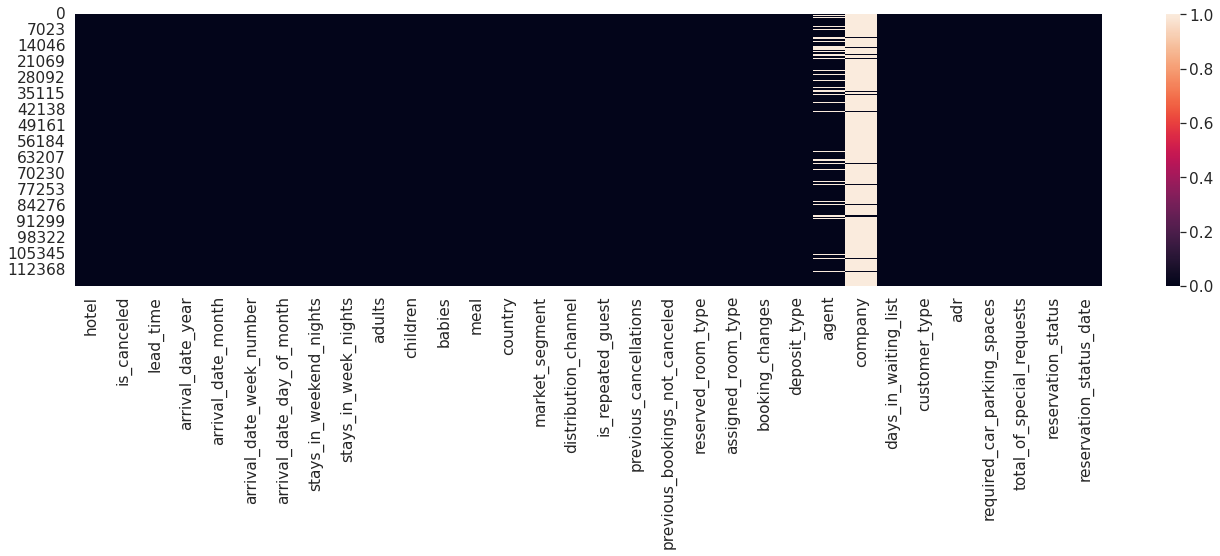

In [ ]:
show_null_heatmap(combined)

Checking the percentage of null values per column, we can identify the columns of `children`, `country`, `agent`, and `company` as having null values. As both `children` and `country` have a `<1%` of values as null, we can drop those null values without significant effect on the dataset. However, `agent` has `13.69%` of values as null, and `company` has `94.3%` of values as null. Additionally, the `agent` and `company` columns being ID values are categorical values rather than numerical data, and extrapolating it with dummy data can cause significant increases in the number of columns. As this amount of null values makes it too significant to simply drop the rows, and these values are not estimatable due to their nature as ID values, these columns are dropped. Combined with the heatmaps, the dataset is considerably clean with the exception of the `agent` and `company` columns.

####Imbalance Analysis

In [ ]:
get_relative_entropy(combined)

0.9509911894723302

Considering the `relative entropy` is high, the target variables are considered balanced enough to not requiring artificial balancing.

####Categoricals analysis

In [ ]:
combined.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [ ]:
combined.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [ ]:
canceled = combined.where(combined["reservation_status"].isin(["Canceled", "No-Show"]))["is_canceled"].dropna()
print(f"Canceled and No-Show unique values: {canceled.unique()}")
check_out = combined.where(combined["reservation_status"].isin(["Check-Out"]))["is_canceled"].dropna()
print(f"Check-Out unique values: {check_out.unique()}")


Canceled and No-Show unique values: [1.]
Check-Out unique values: [0.]


Within the `reservations_status` column, the categories of:
* `Check-Out` -> Room sale was completed succesfully
* `Canceled` -> Booking was canceled
* `No-Show` -> Booking was not canceled but guest did not show up

As evident from the unique values:
* All items with `reservation_status` of `Canceled` and `No-Show` have an `is_canceled` value of `1.0`
* All items in `Check-Out` have an `is_canceled` value of `0.0`

As such, the `reservation_status` column is directly indicative of the `is_canceled` target variable.

In [ ]:
categoricals = ["hotel", "is_canceled", "is_repeated_guest", "deposit_type", "customer_type", "reservation_status", "meal", "market_segment", "distribution_channel", "country"]

In [ ]:
show_categorical_values(combined, categoricals)

hotel               : ['Resort Hotel' 'City Hotel']
is_canceled         : [0 1]
is_repeated_guest   : [0 1]
deposit_type        : ['No Deposit' 'Refundable' 'Non Refund']
customer_type       : ['Transient' 'Contract' 'Transient-Party' 'Group']
reservation_status  : ['Check-Out' 'Canceled' 'No-Show']
meal                : ['BB' 'FB' 'HB' 'SC' 'Undefined']
market_segment      : ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']
distribution_channel: ['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']
country             : ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL'

From the above categoricals, we can see that `meal`, `market_segment`, and `distribution_channel` have values of `Undefined`. As this is likely unrepresentative of the reality of those bookings, we look into these columns further to identify potential actions

In [ ]:
analyse_category(combined, "meal")

meal
BB           77.318033
FB            0.668398
HB           12.114080
SC            8.920345
Undefined     0.979144
Name: meal, dtype: float64

In [ ]:
analyse_category(combined, "market_segment")

market_segment
Aviation          0.198509
Complementary     0.622330
Corporate         4.435045
Direct           10.558673
Groups           16.593517
Offline TA/TO    20.285619
Online TA        47.304632
Undefined         0.001675
Name: market_segment, dtype: float64

In [ ]:
analyse_category(combined, "distribution_channel")

distribution_channel
Corporate     5.592596
Direct       12.266521
GDS           0.161655
TA/TO        81.975040
Undefined     0.004188
Name: distribution_channel, dtype: float64

As can be seen by the percentages, `Undefined` makes up less than `1%` of each column. As they are unlikely to be representative of the reality, the rows containing `Undefined` may be dropped without significant effect on the dataset's size. However, according to the dataset descriptions, `Undefined` is equivalent to `SC` in `meal`. As such, `Undefined` can be recategorized as `SC`.

####Data Visualisation

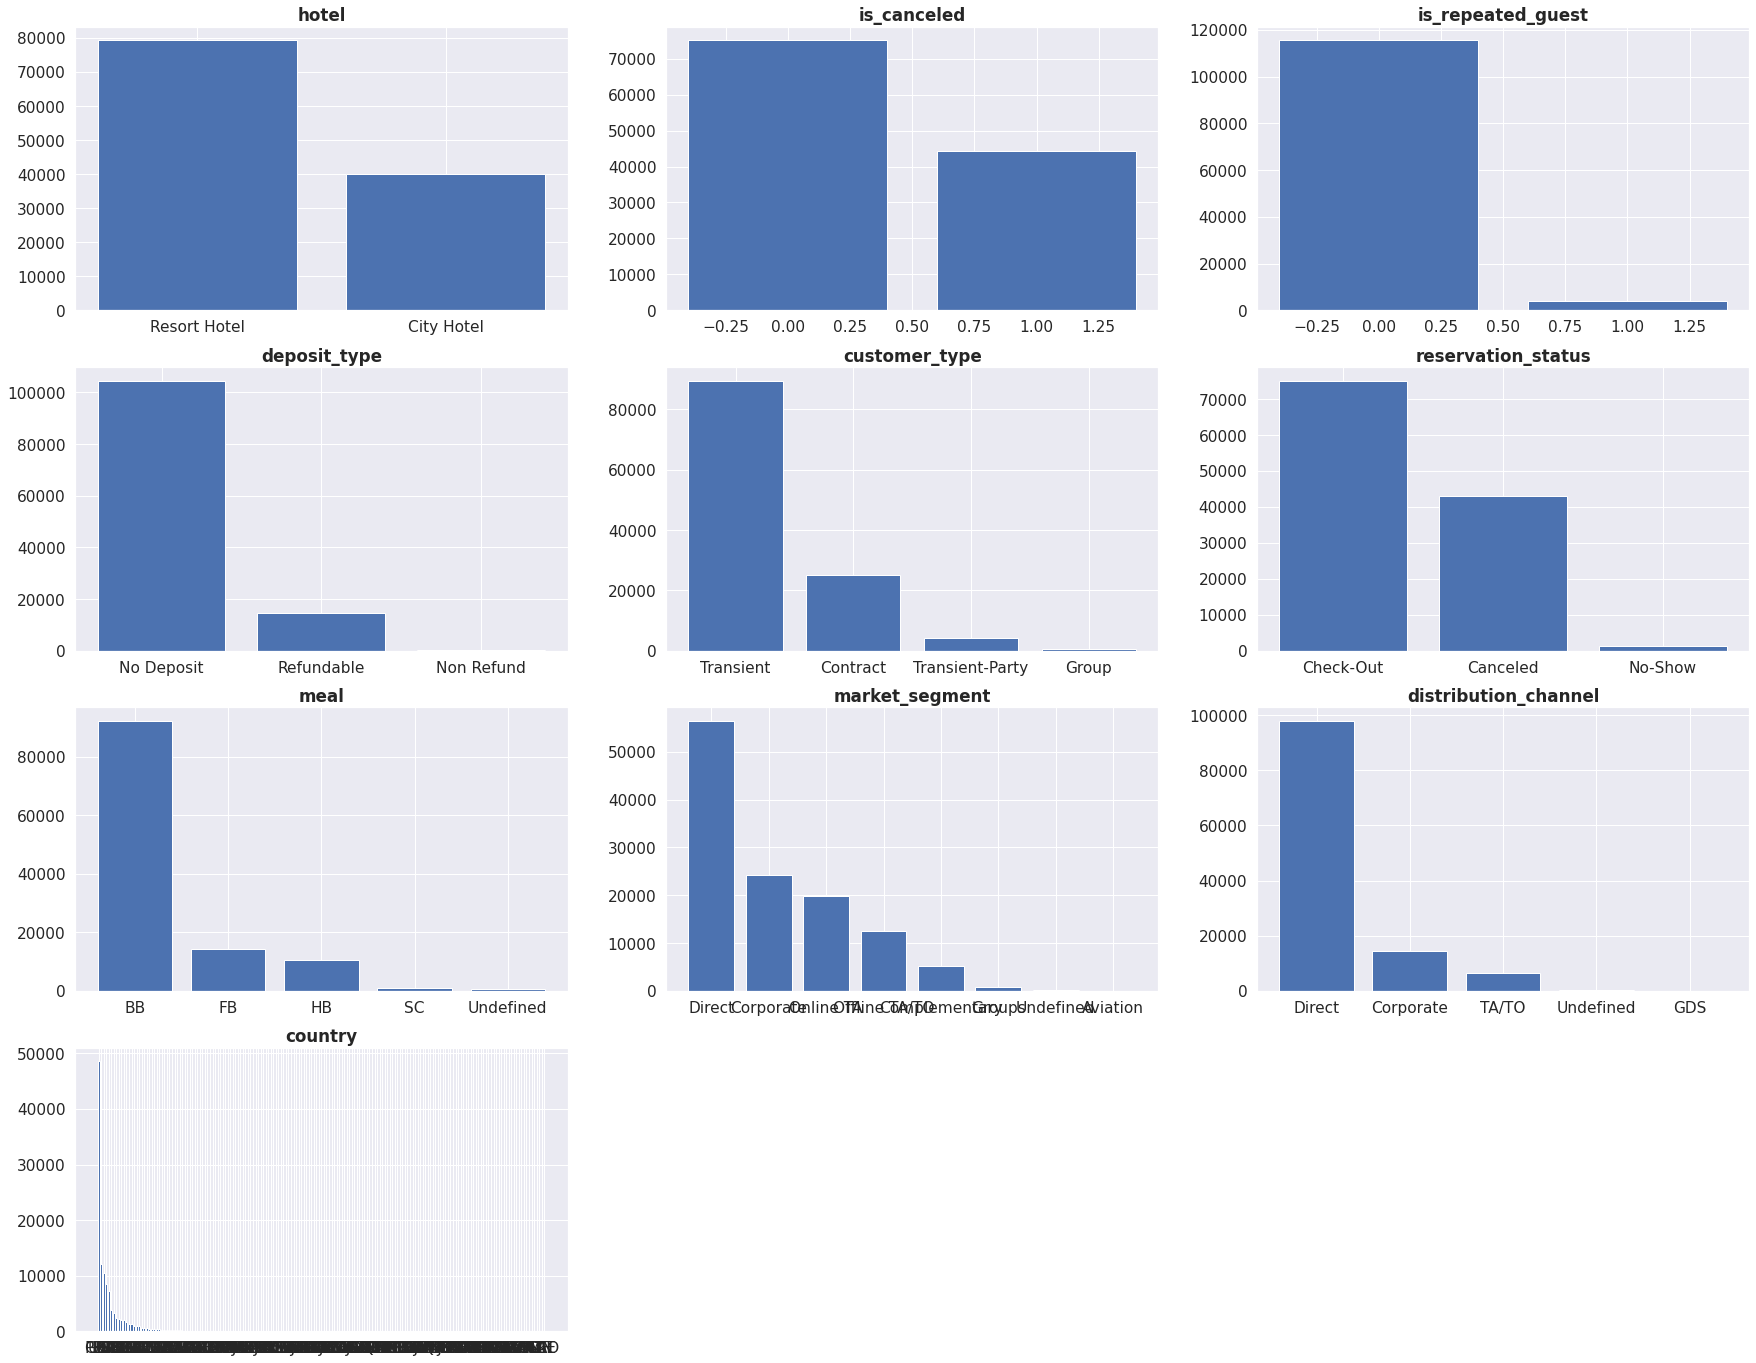

In [ ]:
visualize_categoricals(combined, categoricals)

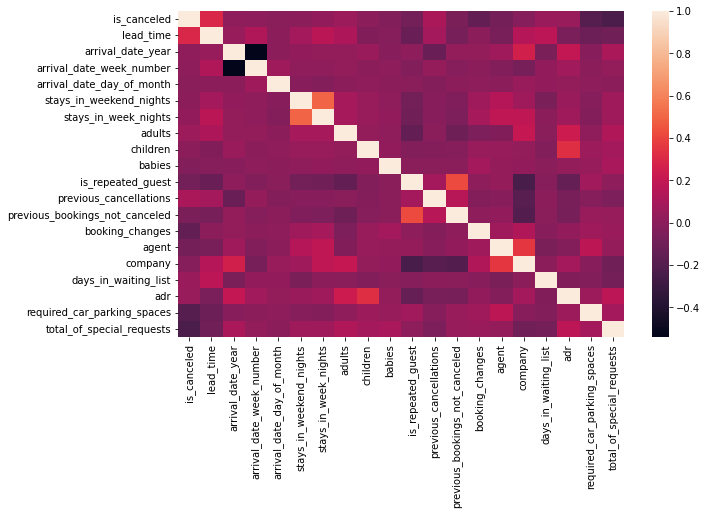

                                correlation >= 0.5
is_canceled                                  False
lead_time                                    False
arrival_date_year                            False
arrival_date_week_number                     False
arrival_date_day_of_month                    False
stays_in_weekend_nights                      False
stays_in_week_nights                         False
adults                                       False
children                                     False
babies                                       False
is_repeated_guest                            False
previous_cancellations                       False
previous_bookings_not_canceled               False
booking_changes                              False
agent                                        False
company                                      False
days_in_waiting_list                         False
adr                                          False
required_car_parking_spaces    

In [ ]:
corr_matrix = show_correlation_matrix(combined)

Looking at the heatmap, there are some values which have a higher correlation than others. However, when a filter is applied on the values of the correlation, none of the correlations have a max value of `>=0.5`. As such, the correlation between columns is not significant.

In [ ]:
show_cancelations_by_time(combined)

                   total_bookings  total_cancelations  rate_of_cancelations
arrival_date_year                                                          
2015                        21996                8142             37.015821
2016                        56707               20337             35.863297
2017                        40687               15745             38.697864

Mean/Standard Deviation of rate of cancelations
mean    37.192328
std      1.425503
dtype: float64


In [ ]:
show_start_end(combined)

   Arrival Year  Earliest arrival week  Latest arrival week
0          2015                   27.0                 53.0
1          2016                    1.0                 53.0
2          2017                    1.0                 35.0


As can be seen by the total number of bookings, number of cancellations, and percentage of cancellations, 2015 had a significantly lower number of cancellations which can be attributed to the significantly lower number of total bookings recorded. This would be due to the first `arrival_date_week_number` for `arrival_date_year` of `2015` being `27`, indicating that it had only began recording the information at about halfway through the year. Similarly, if we look at `arrival_date_year` of `2018`, the latest `arrival_date_week_number` would be `35`, indicating that the collection of data ended part way through the year. As such, the raw booking and cancelation numbers for each year may not be completely indicative.


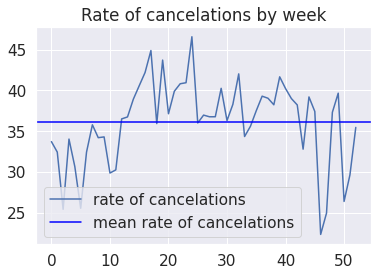

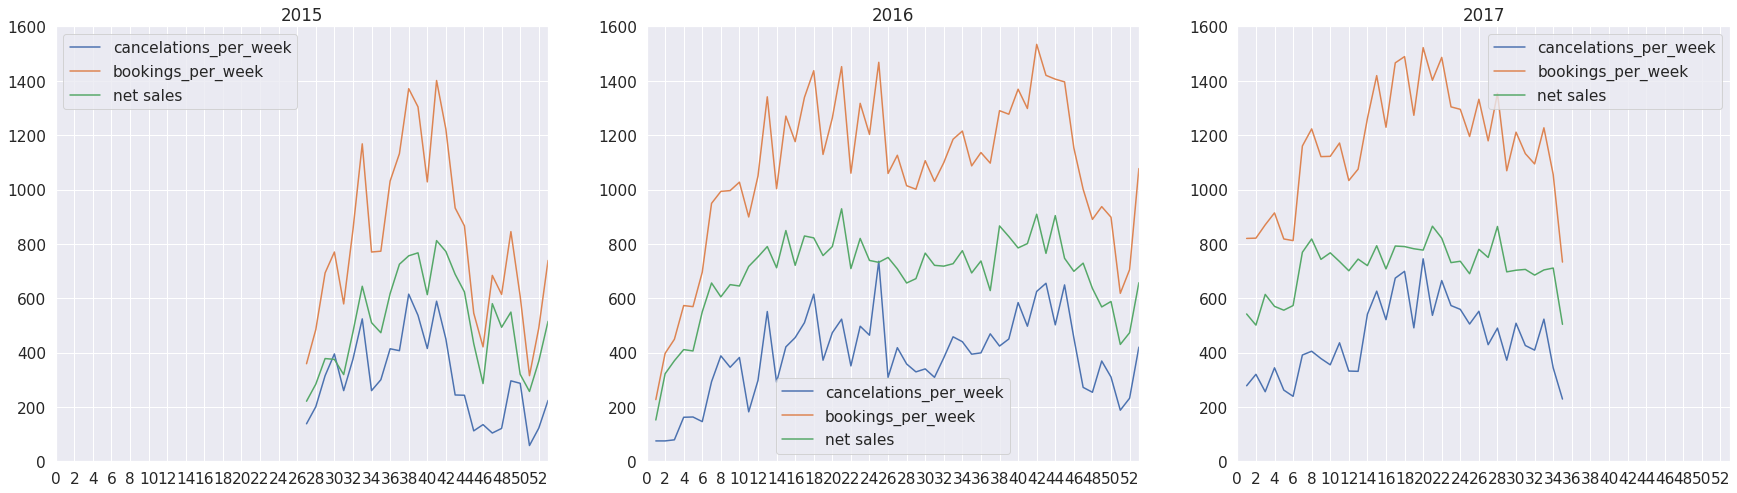

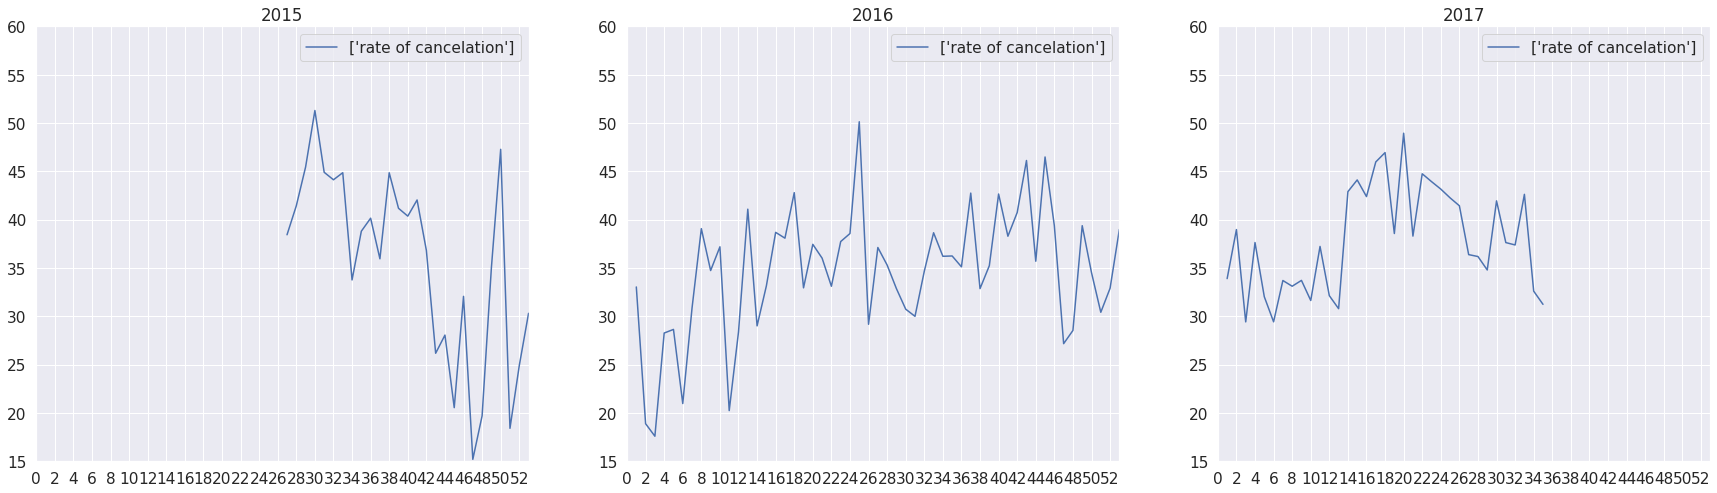

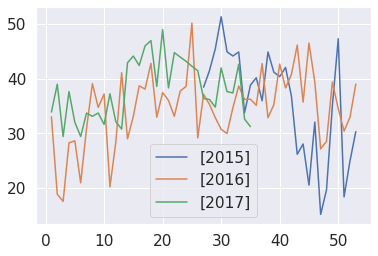

In [ ]:
show_rate_of_cancelations_by_week(combined)

Additionally, as the rate of cancelations show a pattern of being lower at the start and ends of the year, the averages from `2015` and `2017` would be higher as they do not encompass the entire year. By looking at the per-week data, we can see that the per-week rate of cancelations do not show a clear pattern acorss the three years.

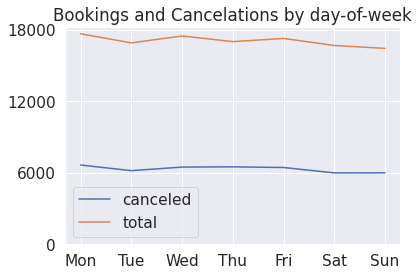

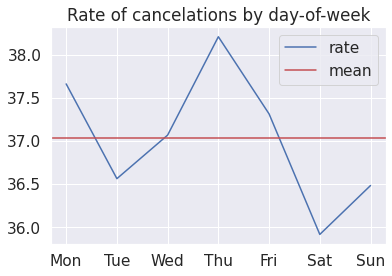

In [ ]:
cancelations_by_day_of_week(combined)

The change in rate of cancelations don't show signficant changes in value across the days, with a max of approximately `38.4%` and a min of approximately `35.8%`.

###Numericals analysis

In [ ]:
numericals = ["lead_time", "stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies", "previous_cancellations", "previous_bookings_not_canceled", "booking_changes", "days_in_waiting_list", "adr", "required_car_parking_spaces", "total_of_special_requests"]

In [ ]:
combined['children'].shape

(119390,)

In [ ]:
combined.dropna(subset=['children'], inplace=True)

In [ ]:
combined['children'] = combined['children'].astype(int)

In [ ]:
combined[numericals].dtypes

lead_time                           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int64
babies                              int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
days_in_waiting_list                int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
dtype: object

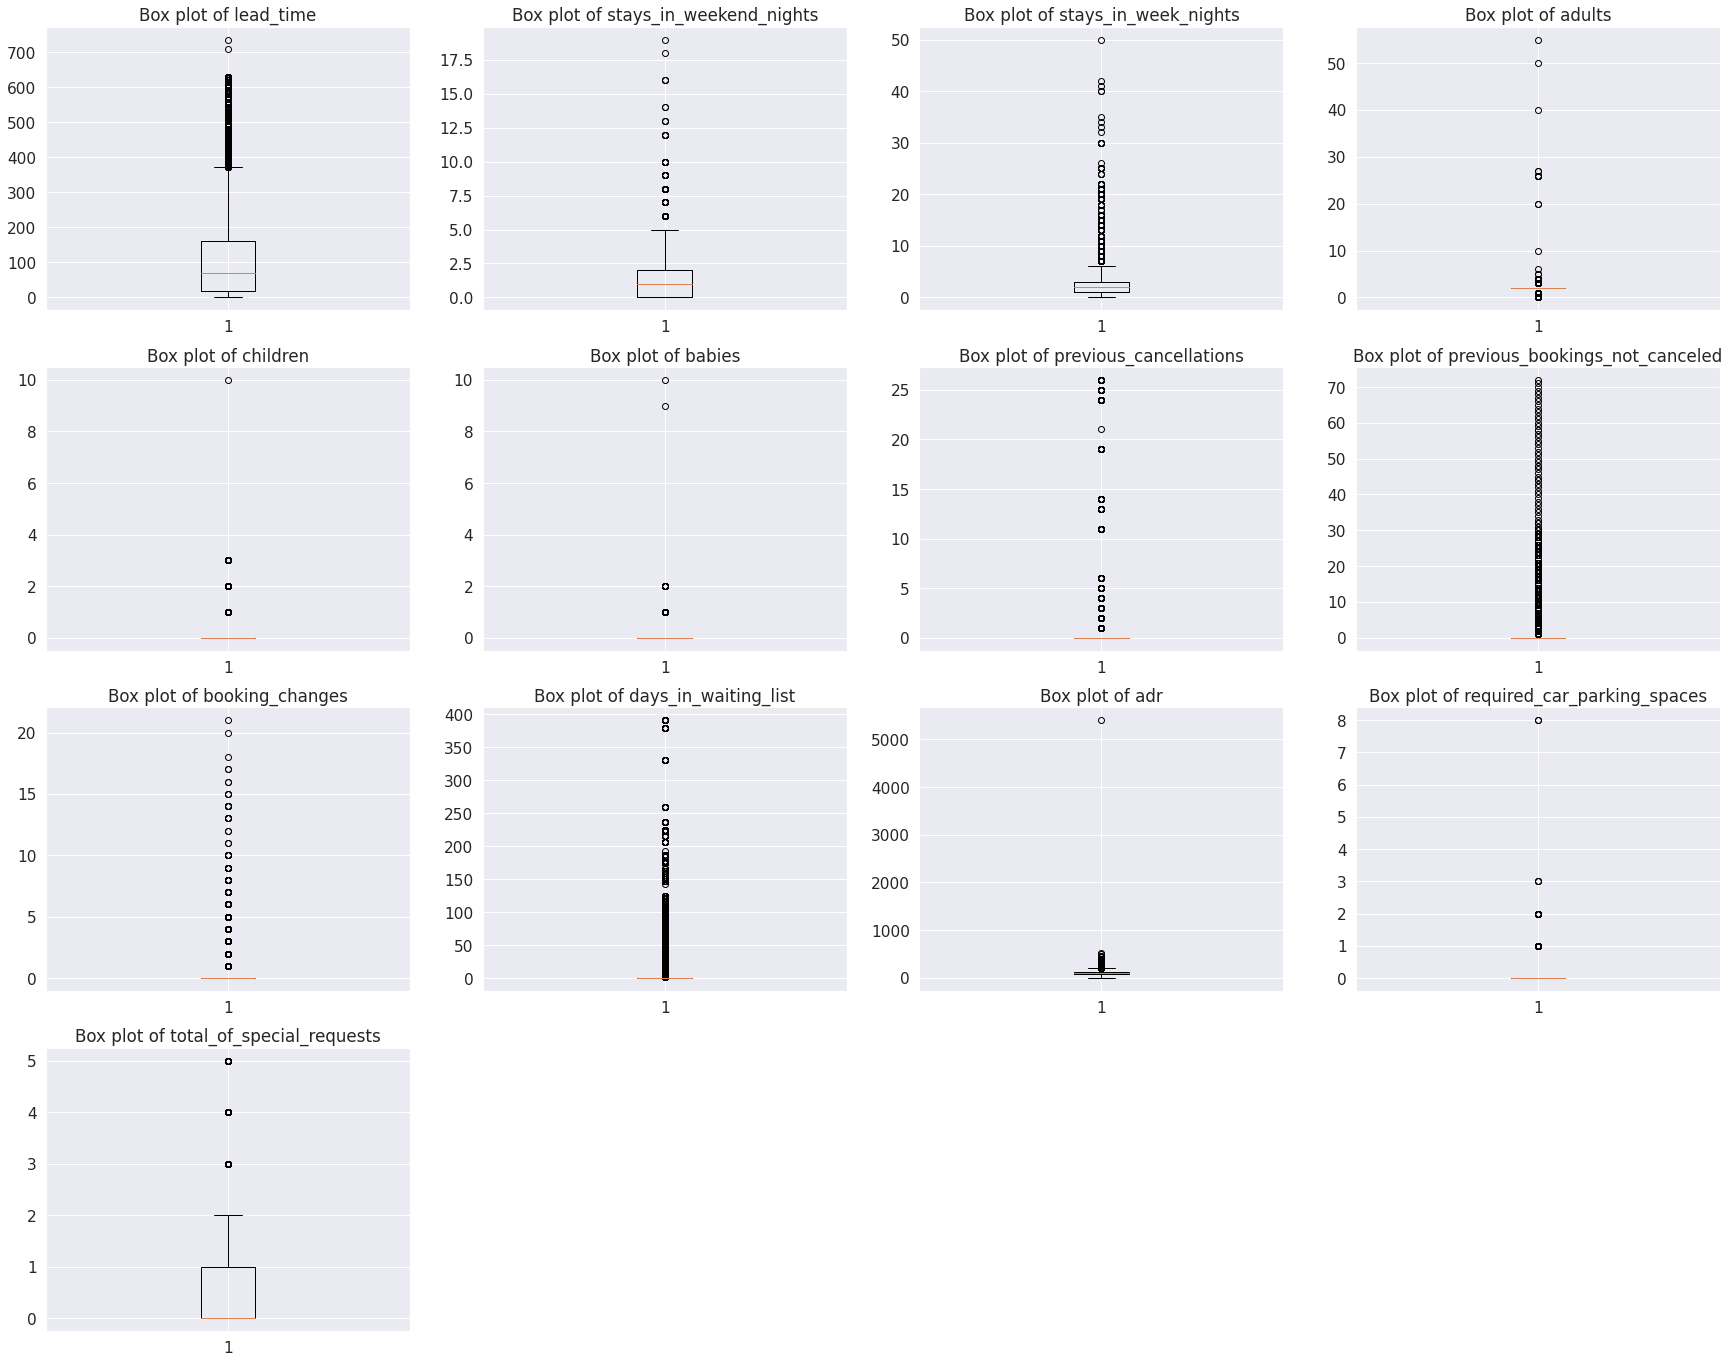

In [ ]:
analyse_numericals(combined, numericals)

In [ ]:
count_outliers(combined, numericals)

                                Number of outliers
lead_time                                     1454
stays_in_weekend_nights                       2199
stays_in_week_nights                          1669
adults                                         481
children                                      3729
babies                                         917
previous_cancellations                         317
previous_bookings_not_canceled                 936
booking_changes                               1570
days_in_waiting_list                          1871
adr                                           1138
required_car_parking_spaces                   7416
total_of_special_requests                     2877


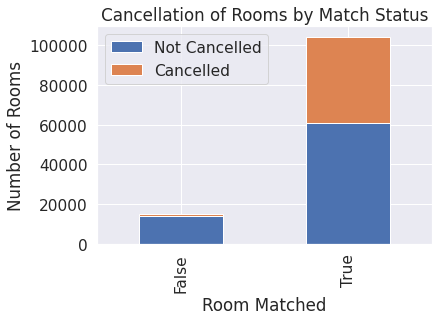

                   Rate of cancelation
Room match status                     
False                         5.376416
True                         41.560654


In [ ]:
show_room_matched(combined)

The rate of cancelations increase significantly if the assigned room and booked room types match. While this may be counterintuitive, this may be more indicative of the state of the region. 

For example, in the event that many hotels in an area are fully booked, many guests may not be able to get the room type that they booked. In this case, they may perceive that they would be unable to obtain a room in another location, they would be less likely to cancel.

###Conclusion of Combined EDA

The presence of null values in `children` and `country` and null-like values in `meal`, `market_segment`, and `distribution_channel` form a low percentage of rows of the total dataset. As such, these are not values that can be estimated by any other row, these rows may be dropped while still having a negligble effect on the overall dataset. 

However, the `agent` and `company` columns contain a significant amount of null values. As these values are also un-estimatable due to their nature as ID values, these columns should be dropped.

Furthermore, the `reservation_status` column is directly indicative of the target variable. It is also a data point that would be theoretically unavailable for useful predictions, since this feature would only emerge after the booking date. As such, `reservation_status` and `reservation_status_date` should be dropped.

##Per Hotel Type *EDA*

In [ ]:
#EDA of separate
df.groupby("hotel").head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03
40060,City Hotel,0,6,2015,July,27,1,0,2,1,...,No Deposit,6.0,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-03
40061,City Hotel,1,88,2015,July,27,1,0,4,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,1,Canceled,2015-07-01
40062,City Hotel,1,65,2015,July,27,1,0,4,1,...,No Deposit,9.0,NaN,0,Transient,68.0,0,1,Canceled,2015-04-30
40063,City Hotel,1,92,2015,July,27,1,2,4,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,2,Canceled,2015-06-23
40064,City Hotel,1,100,2015,July,27,2,0,2,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,1,Canceled,2015-04-02


In [ ]:
# Resort
resort_hotel = df[df['hotel'] == 'Resort Hotel']
resort_hotel.head()
# City Hotel
city_hotel = df[df['hotel'] == 'City Hotel']
city_hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
40060,City Hotel,0,6,2015,July,27,1,0,2,1,...,No Deposit,6.0,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-03
40061,City Hotel,1,88,2015,July,27,1,0,4,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,1,Canceled,2015-07-01
40062,City Hotel,1,65,2015,July,27,1,0,4,1,...,No Deposit,9.0,NaN,0,Transient,68.0,0,1,Canceled,2015-04-30
40063,City Hotel,1,92,2015,July,27,1,2,4,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,2,Canceled,2015-06-23
40064,City Hotel,1,100,2015,July,27,2,0,2,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,1,Canceled,2015-04-02


In [ ]:
get_number_of_nulls(resort_hotel)

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                             464
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              8209
company                           36952


In [ ]:
get_rate_of_nulls(resort_hotel)

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.000000
babies                             0.000000
meal                               0.000000
country                            1.158263
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

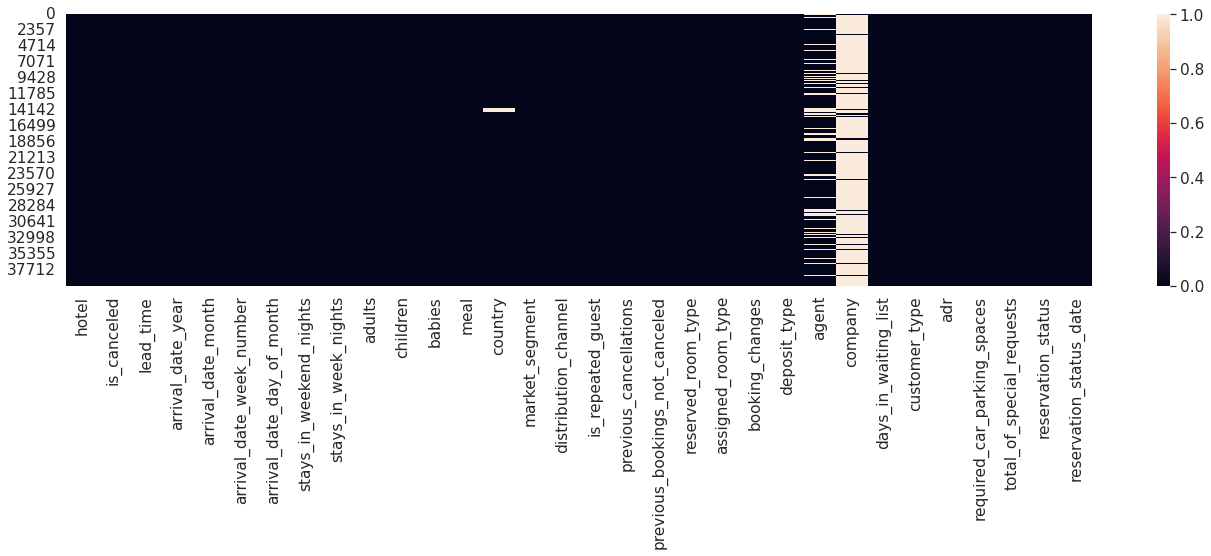

In [ ]:
show_null_heatmap(resort_hotel)

We have significantly higher missing country values here compared to city_hotel df

In [ ]:
get_number_of_nulls(city_hotel)

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                              24
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              8131
company                           75641


In [ ]:
get_rate_of_nulls(city_hotel)

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.005042
babies                             0.000000
meal                               0.000000
country                            0.030253
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

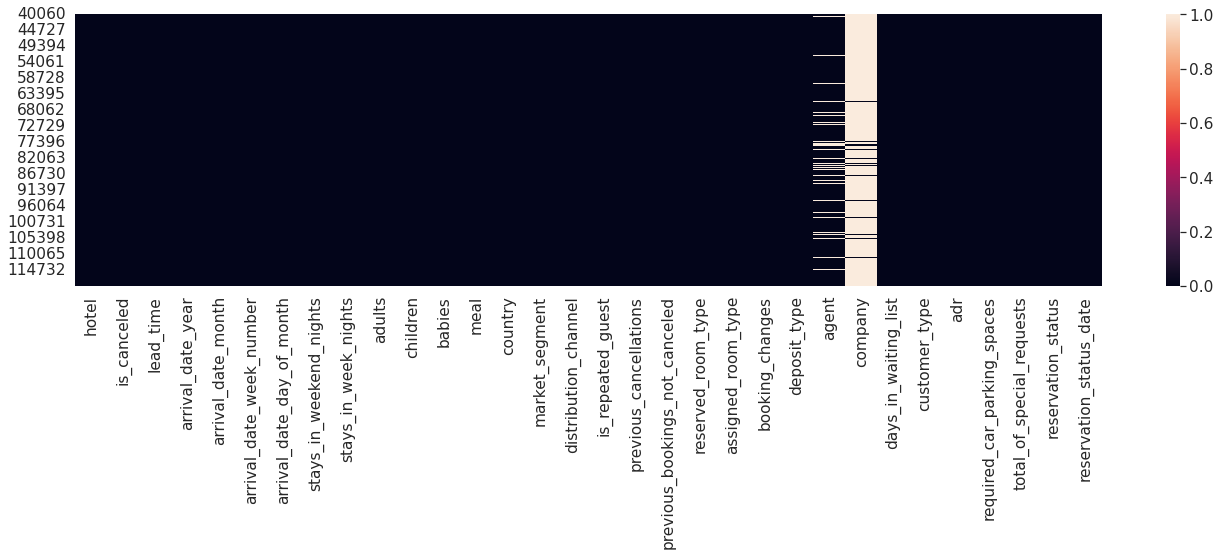

In [ ]:
show_null_heatmap(city_hotel)

In [ ]:
get_relative_entropy(city_hotel)

0.9801603739102189

In [ ]:
get_relative_entropy(resort_hotel)

0.8522062837305147

Looking at the `relative entropy`, the target variable of `is_canceled` is more imbalanced in Resort Hotels. While balancing through oversampling or undersampling can improve it, the divergence is not considered serious enough to require it.

#Data Pre-processing

####Data Cleaning

In [ ]:
cleaned = df.copy()

In [ ]:
cleaned.shape

(119390, 32)

In [ ]:
cleaned.drop(['agent', 'company'], axis=1, inplace=True)

In [ ]:
cleaned.dropna(subset=['children', 'country'], inplace=True)

In [ ]:
cleaned['meal'].replace('Undefined', 'SC', inplace=True)
cleaned.drop(cleaned[cleaned['market_segment'] == 'Undefined'].index, inplace=True)
cleaned.drop(cleaned[cleaned['distribution_channel'] == 'Undefined'].index, inplace=True)

After analysing and identifying the columns and rows that can be dropped, we proceed to clean the dataset. As stated earlier, we will be dropping:

* Columns: `agent`, `company`    
* Rows:   
 * Null values in columns `children` and `country`   
 * `Undefined` values in columns `market_segment`, and `distribution_channel`

And reclassifying `Undefined` in `meal` as `SC`.

#Feature Engineering

In [ ]:
cleaned.drop(['reservation_status', 'reservation_status_date'], axis=1, inplace=True)

As discussed in the Exploratory Data Analysis, `reservation_status` and `reservation_status_date` are dropped.

In [ ]:
#do we want to have it as an explicit column? If so do we want to keep the room types individually?
cleaned['matched'] = cleaned['reserved_room_type'] == cleaned['assigned_room_type']
cleaned['matched'] = cleaned['matched'].apply(lambda x: 1 if x else 0)

In [ ]:
months = {"JANUARY" : 1,"FEBRUARY" : 2,"MARCH" : 3,"APRIL": 4, "MAY": 5, "JUNE": 6, "JULY": 7, "AUGUST": 8, "SEPTEMBER": 9, "OCTOBER": 10, "NOVEMBER": 11, "DECEMBER": 12}
cleaned['arrival_date_month'] = cleaned['arrival_date_month'].apply(lambda x: months[str(x).upper()])

In [ ]:
cyclical_features = CyclicalFeatures(["arrival_date_month", "arrival_date_week_number", "arrival_date_day_of_month"], drop_original=False)
cleaned = cyclical_features.fit_transform(cleaned)

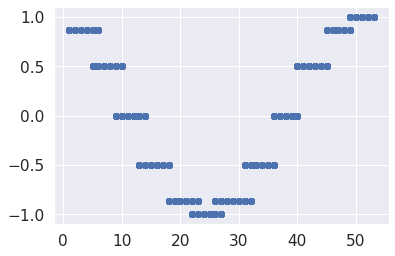

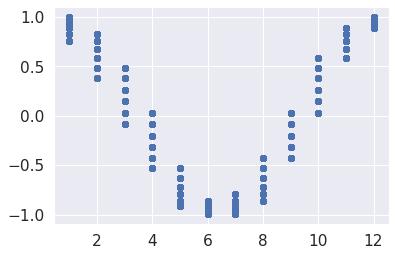

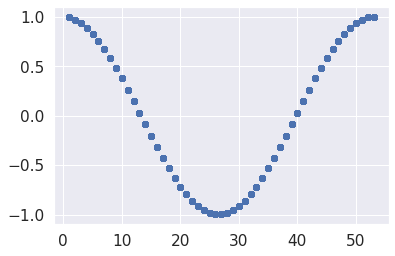

In [ ]:
plt.scatter(cleaned["arrival_date_week_number"], cleaned["arrival_date_month_cos"])
plt.show()
plt.scatter(cleaned["arrival_date_month"], cleaned["arrival_date_week_number_cos"])
plt.show()

plt.scatter(cleaned["arrival_date_week_number"], cleaned["arrival_date_week_number_cos"])
plt.show()

To facilitate the model training, we convert the month string into its equivalent numeric value.

In [ ]:
categories = ["hotel", "deposit_type", "customer_type", "meal", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "country"]
for cat in categories:
    temp_df = pd.get_dummies(cleaned[cat])
    cleaned = pd.concat([cleaned, temp_df], axis=1)

cleaned = cleaned.drop(categories, axis=1)

Dummy data is created out of the remaining categorical data, which causes an increase in the amount of columns to accomodate the individual categories for each category type.

what to add? matched? remove the dates (makes it able to better generalise to "future" predictions, plus there's no clear pattern across the years and may act as noise to the prediction)? identify and potentially drop outliers in numericals?

In [ ]:
cleaned.shape

(118897, 249)

In [ ]:
dropped = cleaned.drop_duplicates(keep="first")
print(dropped.shape)

(86654, 249)


In [ ]:
dropped["is_canceled"].mean()

0.27377847531562305

In [ ]:
df["is_canceled"].mean()

0.37041628277075134

In [ ]:
df[df.duplicated()]["is_canceled"].mean()

0.6313371257110708

In [ ]:
get_rate_of_nulls(df.drop_duplicates(keep="first"))

hotel                              0.000000
is_canceled                        0.000000
lead_time                          0.000000
arrival_date_year                  0.000000
arrival_date_month                 0.000000
arrival_date_week_number           0.000000
arrival_date_day_of_month          0.000000
stays_in_weekend_nights            0.000000
stays_in_week_nights               0.000000
adults                             0.000000
children                           0.004577
babies                             0.000000
meal                               0.000000
country                            0.517186
market_segment                     0.000000
distribution_channel               0.000000
is_repeated_guest                  0.000000
previous_cancellations             0.000000
previous_bookings_not_canceled     0.000000
reserved_room_type                 0.000000
assigned_room_type                 0.000000
booking_changes                    0.000000
deposit_type                    

In [ ]:
cleaned = dropped
y = np.array(cleaned["is_canceled"])
X = np.array(cleaned.drop(['is_canceled'], axis=1))